In [198]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
# set seed
np.random.seed(142857)
torch.set_default_tensor_type(torch.DoubleTensor)

# set dependency parameter


data = pd.read_csv('Steel_industry_data.csv', delimiter=',').drop(['date'],axis = 1)
# drop index 29855, because it contins t=0
data.drop([29855],inplace=True)

print(data.columns)
# encode categorical variables
data_encoded = pd.get_dummies(data, columns=['WeekStatus', 'Day_of_week', 'Load_Type'])

cols_to_scale = [ 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
scaler = StandardScaler()
scaler.fit(data_encoded[cols_to_scale])


data_encoded[cols_to_scale] = scaler.transform(data_encoded[cols_to_scale])


# # covert data to tensor, only use numerical covariates for now
covariates = data_encoded.drop(['Usage_kWh'],axis = 1).values
n_features = covariates.shape[1]

covariates_tensor = torch.tensor(covariates)
time_tensor = torch.tensor(data['Usage_kWh'].values)
event_tensor = torch.ones_like(time_tensor)

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


In [199]:

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define our Weibull CoxPH model, but all data is event = 1
class WeibullModel(nn.Module):
    def __init__(self, num_features, hidden_size = 128):
        super(WeibullModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.Linear(hidden_size, 1),
        )
        self.shape = nn.Parameter(torch.tensor(1.0))
        self.scale = nn.Parameter(torch.tensor(1.0))

    def log_likelihood(self, x, t, c):
        x_beta = self.net(x).squeeze()
        log_hazard = torch.log(self.shape) - torch.log(self.scale) + (self.shape -1)* (torch.log(t) - torch.log(self.scale)) + x_beta
        log_survival = -(t/self.scale)**self.shape * torch.exp(x_beta)
        log_density = log_hazard + log_survival
        return torch.sum(log_density)
    def survival_function(self,x,t):
        with torch.no_grad():
            x_beta = self.net(x).squeeze()
            return torch.exp(-(t/self.scale)**self.shape * torch.exp(x_beta))
    def calculate_risk(self,x):
        with torch.no_grad():
            x_beta = self.net(x).squeeze()
            return x_beta

In [200]:
covariates_tensor = torch.tensor(covariates, dtype=torch.float64).to(device)
time_tensor = torch.tensor(data['Usage_kWh'], dtype=torch.float64).to(device)
event_tensor = torch.ones_like(time_tensor, dtype=torch.float64).to(device)

# Define our Weibull survival model
model = WeibullModel(n_features).to(device)

# Create an optimizer
optimizer = optim.Adam( [{"params": [model.scale], "lr": 0.005},
                          {"params": [model.shape], "lr": 0.001},
                          {"params": model.net.parameters(), "lr": 0.001}
                          ])

# Define the number of epochs and the likelihood threshold
num_epochs = 50000
likelihood_threshold = 1e-16
prev_log_likelihood = 0
# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model.log_likelihood(covariates_tensor, time_tensor, event_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")
        print(f"Estimated Shape: {model.shape.item()}, Estimated Scale: {model.scale.item()}")

    # if improvement in log-likelihood is below threshold, stop training
    if epoch > 0 and abs(log_likelihood - prev_log_likelihood) < likelihood_threshold: 
        print(f"Converged at Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")
        print(f"Estimated Shape: {model.shape.item()}, Estimated Scale: {model.scale.item()}")
        break
    prev_log_likelihood = log_likelihood

Epoch 0, Log-Likelihood: -766601.8633548219
Estimated Shape: 0.999, Estimated Scale: 1.005
Epoch 1000, Log-Likelihood: -117720.33890625605
Estimated Shape: 1.0740083277455321, Estimated Scale: 1.1941655095983914
Epoch 2000, Log-Likelihood: -111822.28264047441
Estimated Shape: 1.2932142803708502, Estimated Scale: 1.2066558741734434
Epoch 3000, Log-Likelihood: -105597.5621344693
Estimated Shape: 1.589683125106928, Estimated Scale: 1.2225317586493722
Epoch 4000, Log-Likelihood: -99922.99500767696
Estimated Shape: 1.9480111627126155, Estimated Scale: 1.2392778990017743
Epoch 5000, Log-Likelihood: -95216.10617870864
Estimated Shape: 2.353671544361746, Estimated Scale: 1.2559077647368588
Epoch 6000, Log-Likelihood: -91642.65559782932
Estimated Shape: 2.788287095712595, Estimated Scale: 1.2718080266906955
Epoch 7000, Log-Likelihood: -89198.10115795018
Estimated Shape: 3.2279383331817386, Estimated Scale: 1.2864549579596882
Epoch 8000, Log-Likelihood: -87746.58622713017
Estimated Shape: 3.6424

/tmp/ipykernel_27856/1796635300.py:7: RuntimeWarning: overflow encountered in power
  temp1 = np.power(u,-theta)


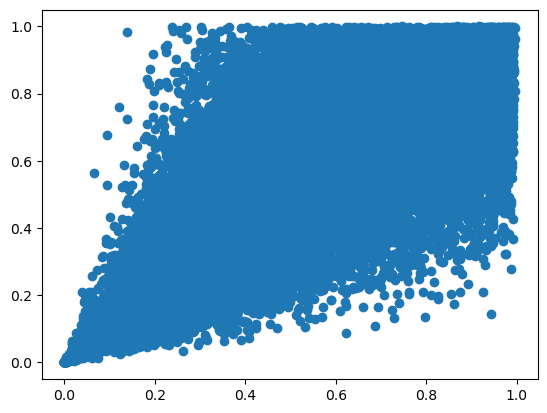

/home/weijia/anaconda3/lib/python3.10/site-packages/statsmodels/tools/rng_qrng.py:54: FutureWarning: Passing `None` as the seed currently return the NumPy singleton RandomState
(np.random.mtrand._rand). After release 0.13 this will change to using the
default generator provided by NumPy (np.random.default_rng()). If you need
reproducible draws, you should pass a seeded np.random.Generator, e.g.,

import numpy as np
seed = 32839283923801
rng = np.random.default_rng(seed)"

  warnings.warn(_future_warn, FutureWarning)


3.643409984462485

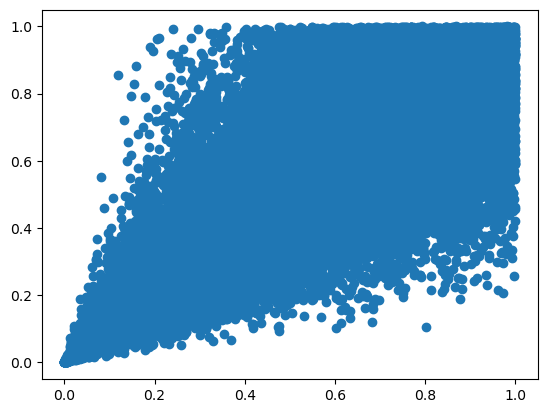

In [191]:
theta = 4


import matplotlib.pyplot as plt
# define conditional distribution approach  
def clayton_conditional(u,v,theta=2):
    temp1 = np.power(u,-theta)
    temp2 = np.power(v,-theta/(theta+1))-1
    temp3 = temp1*temp2+1
    return np.power(temp3,-1/theta)
    # return (u**(-theta)*(v**(-theta/(theta+1))-1)+1)**(-1/theta)

# generate random variable uniformly from 0 to 1
## PROBLEM: here u is not uniformly distributed, so the generation here may have problem!
u = model.survival_function(covariates_tensor,time_tensor).cpu().detach().numpy()
t = np.random.uniform(0, 1, np.size(u))

# Now, (u,v) are uniformly distributed in [0,1]^2, and joint CDF is given by the Clayton Copula with parameter theta
v = clayton_conditional(u,t, theta = theta)
plt.scatter(u, v)
plt.show()

# visually check if the generation looks similar to the true copula
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, FrankCopula, ClaytonCopula)
copula = ClaytonCopula(theta=theta)
sample = copula.rvs(35039)
plt.scatter(sample[:,0],sample[:,1])
copula = ClaytonCopula()
copula.fit_corr_param(np.array([u,v]).T)



3.7853055000305176 1.132067084312439
3.2175096750259398 1.3018771469593047
0.9292217243642799


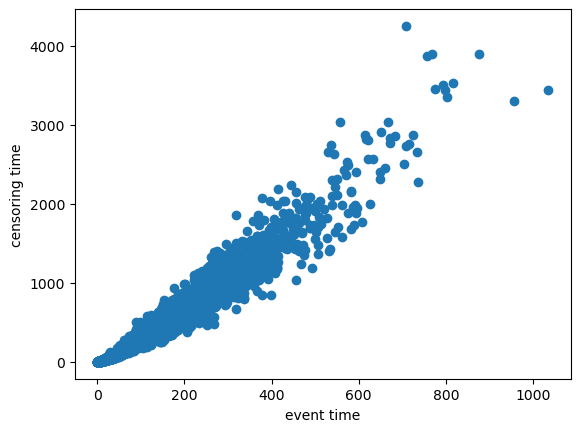

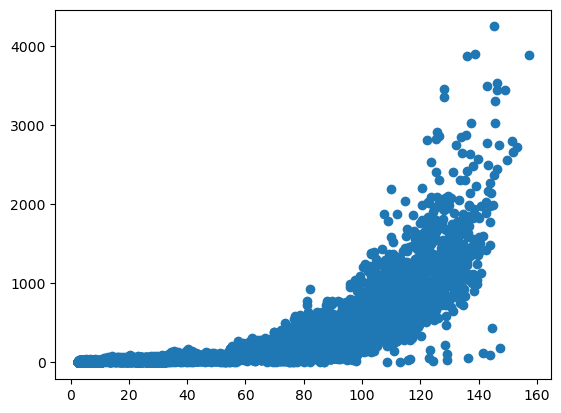

In [187]:
event_shape = model.shape.item()
event_scale = model.scale.item()
print(event_shape, event_scale)

censoring_shape = event_shape *0.85
censoring_scale = event_scale *1.15
print(censoring_shape, censoring_scale)

import copy
model_C = copy.deepcopy(model)

def add_noise_to_weights(tensor, mean=0, std=0.05):
    noise = torch.normal(mean=mean, std=std, size=tensor.shape)
    return tensor + noise.to(tensor.device)
# Apply noise to weights
for param in model_C.parameters():
    param.data = add_noise_to_weights(param.data)

# Generate according to Algorithm 2 in "Copula-based Deep Survival Models for Dependent Censoring"
def inverse_transform(value, risk, shape, scale):
    # return (-np.log(1-value)/risk)**(1/shape)*scale 
    return np.power(-np.log(1-value)/np.exp(risk), 1/shape)*scale
    # return (-np.log(1-value)/np.exp(risk))**(1/shape)*scale

risk_event = model.calculate_risk(covariates_tensor).cpu().detach().numpy()
risk_censoring = model_C.calculate_risk(covariates_tensor).cpu().detach().numpy()

# Transform back v to the time domain, using the inverse of the Weibull survival function
time_event = inverse_transform(u, risk_event, event_shape, event_scale)
time_censoring = inverse_transform(v, risk_censoring, censoring_shape, censoring_scale)
## Now, time_censoring and time_event follows exactly the fitted Model and Model_C, respectively
## Question, do I need risk_event and risk_censoring saved?

# check event rate, larger is better (more observed event)
event_rate = np.sum(time_event<time_censoring)/len(time_event)
print(np.sum(time_event<time_censoring)/len(time_event))
# create observed time 
observed_time = np.minimum(time_event, time_censoring)
event_indicator = (time_event<time_censoring).astype(int)


plt.scatter(time_event, time_censoring)
plt.xlabel('event time')
plt.ylabel('censoring time')
plt.show()

plt.scatter(data_encoded['Usage_kWh'], time_censoring)

In [164]:
from statsmodels.distributions.copula.api import ClaytonCopula
cp = ClaytonCopula(theta=7)
cp.fit_corr_param(np.array([u,v]).T)

temp = cp.rvs(100000)
cp.fit_corr_param(temp)

6.999063760440604

In [143]:
## Save data 
## Change this to be a runnable script
# combine ndarray into dataframe
data = pd.DataFrame(np.concatenate((covariates, observed_time.reshape(-1,1), event_indicator.reshape(-1,1)),axis=1),\
                    columns=data_encoded.drop(['Usage_kWh'],axis = 1).columns.values.tolist()+['y','event_indicator'])

filename = 'Steel_industry_theta_' + str(theta) + '_event_' + str(event_shape) + '_' + str(event_scale) + '_censoring_' + str(censoring_shape) + '_' + str(censoring_scale) + '_eventrate_' + str(event_rate)+ '.csv'
data.to_csv(filename, index=False)

# when evaluation, we need survival probabilities 